# Классификация текстов
В этом ноутбуке решается задача классификации твитов на русском языке на позитивные и негативные. Основное условие, по которому решение будет считаться засчитанным: выбить точность >0.65 (достаточно низкая для классификации, поэтому ориентируемся хотя бы 0.74-0.75)

Для начала подготовим датасет к чтению:

In [4]:
!gdown --id 1GujrcFzRdo3E7UtUkcrljzDS9czBBy3s
!gdown --id 1vvm-PrV0r2wuGbYYovZSuReYOXpu0JRK

import os, shutil
if not os.path.exists('/content/data'):
  os.makedirs('/content/data')
shutil.move('train.csv', "/content/data")
shutil.move('val.csv', "/content/data")

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1GujrcFzRdo3E7UtUkcrljzDS9czBBy3s
To: /content/train.csv
100% 24.7M/24.7M [00:00<00:00, 59.2MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1vvm-PrV0r2wuGbYYovZSuReYOXpu0JRK
To: /content/val.csv
100% 3.10M/3.10M [00:00<00:00, 91.9MB/s]


'/content/data/val.csv'

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from torchtext.data.utils import get_tokenizer
from collections import Counter, OrderedDict
from torchtext.vocab import vocab as _vocab
import torch
from torch.utils.data import DataLoader

In [6]:
!pip install -q torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0
!pip install -q torchtext==0.12.0
!pip install -q torchdata==0.3.0

посмотрим сбалансированность классов и что происходит в датасете:

In [7]:
import pandas as pd

Посмотрим датасет

In [8]:
df = pd.read_csv('/content/data/train.csv')
df

,id,text,class
0,0,VitaliaPerilova у тебя классные очкиони тебя о...,1
1,1,Никогда не подумала бы что самое приятное на с...,1
2,2,KlimovaElena о дааа вот это я понимаю как никт...,0
3,3,Говорят еле хожу никого не вижу будто живой ме...,0
4,4,то чувство когда понимаешь что завтра можно вы...,1
...,...,...,...
181462,181462,CATAHAHELENA я просто смотрела много серий под...,0
181463,181463,И кстати девчонки когда вышла вечером пробежат...,1
181464,181464,AnnaPolitova trulyalya за борсучка обидно,0
181465,181465,Жалко Березовского Горький конец Но счастье п...,0


Видим, что ники на английском, придется заменить на русское "пользователь" для более эффективной классификации. Смотрим насколько сбалансированная выборка.

<Axes: >

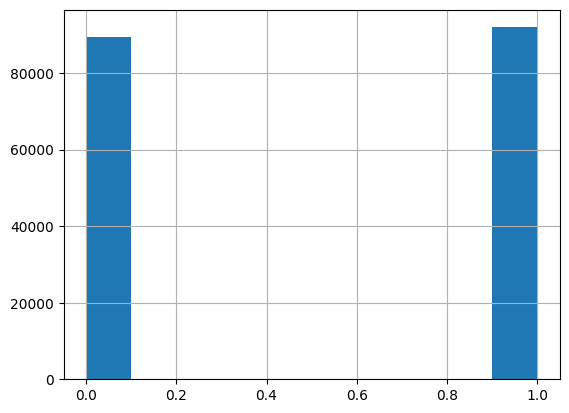

In [9]:
df['class'].hist()

Сбалансированность хорошая, классов поровну, менять и добавлять ничего не будем.

Поехали обрабатывать. Библиотеки устанавливаем:

In [10]:
!pip install pymorphy2

In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
import os
from csv import reader

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:

# Загрузка стоп-слов для русского языка из nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

# Инициализация лемматизатора для русского языка
morph = MorphAnalyzer()

# Функция для лемматизации токенов с фильтрацией стоп-слов
def lemmatize_tokens(tokens):
    return [morph.parse(token)[0].normal_form for token in tokens if token not in stop_words]

# Инициализация стеммера для русского языка
stemmer = SnowballStemmer("russian")

# Функция для стемминга токенов с фильтрацией стоп-слов
def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens if token not in stop_words]

# Предобработка текста
def df_preprocess(text):
    reg = re.compile('[^a-ЯA-яa-zA-Z0-9 ]')
    text = text.lower().replace("ё", "e")
    text = text.replace("ъ", "ь")
    text = text.replace("й", "и")
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', 'сайт', text)
    text = re.sub(r'\b[A-Z][a-zA-Z0-9_]*\b', "пользователь", text)
    text = reg.sub(' ', text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:

# Загрузка данных
def load_data(part):
    data = []
    with open(f"/content/data/{part}.csv", "rt", encoding='utf-8') as f_in:
        r = reader(f_in)
        next(r)
        for row in r:
            _, text, cls = row
            data.append((cls, text))
    return data


In [15]:

# Подготовка данных для обучения и тестирования
train_data = load_data("train")
val_data = load_data("val")

# Предобработка текста и лемматизация
X_train = [" ".join(lemmatize_tokens(nltk.word_tokenize(df_preprocess(text)))) for _, text in train_data]
X_val = [" ".join(lemmatize_tokens(nltk.word_tokenize(df_preprocess(text)))) for _, text in val_data]

y_train = [int(cls) for cls, _ in train_data]
y_val = [int(cls) for cls, _ in val_data]


Есть несколько вариантов моделей, которые здесь применимы, одна из них: классическая логистическая регрессия, поэтому сделаем векторизацию TD-IDF с биграммами, они помогут улучшить качество модели и дадут больше информации. И инициализируем модель лог.регрессии

In [16]:
# Создание и обучение модели с биграммами
model = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2)),  # Добавляем биграммы
    LogisticRegression()
)

model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('logisticregression', LogisticRegression())])

In [17]:

# Предсказание на валидационной выборке
y_pred = model.predict(X_val)

# Оценка качества модели
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


Accuracy: 0.7408632015165543
              precision    recall  f1-score   support

           0       0.74      0.73      0.73     11202
           1       0.74      0.76      0.75     11481

    accuracy                           0.74     22683
   macro avg       0.74      0.74      0.74     22683
weighted avg       0.74      0.74      0.74     22683



Нам этой точность уже достаточно для отправки решения. Можно было бы лучше и попробовать другие модели, но это в следующем проекте.

In [18]:
# Загрузка данных из файла
test_data = pd.read_csv('/content/Soc_Net_Task_2_test_7.csv')
texts = test_data['text'].tolist()

In [19]:
# Предобработка текста и лемматизация
def preprocess_and_lemmatize(text):
    text = df_preprocess(text)
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = lemmatize_tokens(tokens)
    return " ".join(lemmatized_tokens)

processed_texts = [preprocess_and_lemmatize(text) for text in texts]

# Сделать предсказания
y_pred = model.predict(processed_texts)


In [20]:
y_pred

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,

Попробуем с другой моделью

In [21]:
# Создание и обучение модели 2
from sklearn.svm import LinearSVC
model_SVC = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2)),
    LinearSVC(random_state = 30, C = 1.1)
)

model_SVC.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('linearsvc', LinearSVC(C=1.1, random_state=30))])

In [22]:
predictions = model_SVC.predict(X_val)
a = classification_report(y_val, predictions, digits=3, output_dict = True)

#output to var
print('Precision', round(a['macro avg']['precision'],3))
print('Recall', round(a['macro avg']['recall'],3))
print('F-Score', round(a['macro avg']['f1-score'],3))

Precision 0.755
Recall 0.755
F-Score 0.755
